#Part 3

<ipython-input-3-18a9fd462163>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(gcol, group_keys=False).apply(centered_diff)
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


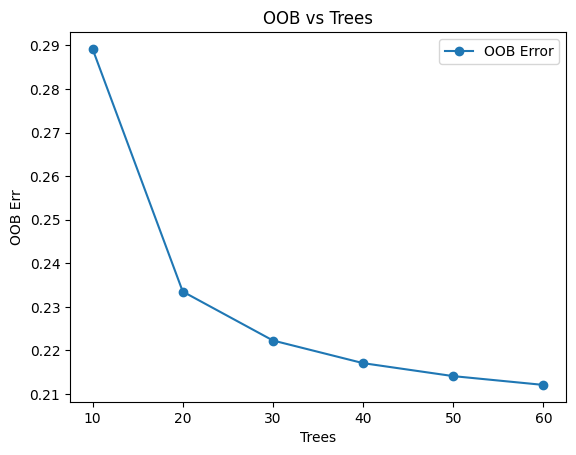

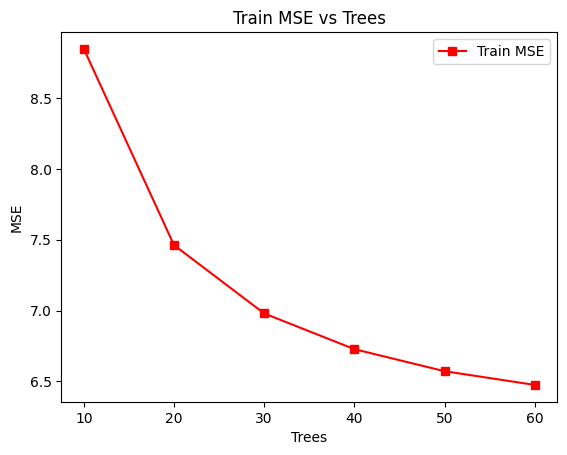

Train(Final) MSE=6.572, MAPE=0.231
Test(3 trips) MSE=89.834, MAPE=1.437
Saved Part3_3Trips_TestResult.xlsx


<ipython-input-3-18a9fd462163>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-3-18a9fd462163>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc["FQ"] = 1.0
<ipython-input-3-18a9fd462163>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc.dropna(subset=fcols, inplace=True)
<ipython-input-3-18a9fd462163>:

Saved Part3_Cluster_TestResult.xlsx.


<ipython-input-3-18a9fd462163>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-3-18a9fd462163>:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc["FQ"] = 1.0
<ipython-input-3-18a9fd462163>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc.dropna(subset=fcols, inplace=True)
<ipython-input-3-18a9fd462163>:

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def centered_diff(df):
    df = df.sort_values("Time").reset_index(drop=True)
    df["TPF_next"] = df["TPF"].shift(-1)
    df["TPF_prev"] = df["TPF"].shift(1)
    df["CM_next"] = df["CM"].shift(-1)
    df["CM_prev"] = df["CM"].shift(1)
    df["DeltaTPF_centered"] = df["TPF_next"] - df["TPF_prev"]
    df["DeltaCM_centered"] = df["CM_next"] - df["CM_prev"]
    df["Fuel_Instant_centered"] = 100.0 * (df["DeltaTPF_centered"] / df["DeltaCM_centered"])
    return df

def mape(a, p):
    a = np.array(a)
    p = np.array(p)
    m = (a != 0)
    a_ = a[m]
    p_ = p[m]
    if len(a_) == 0:
        return None
    return np.mean(np.abs(a_ - p_) / np.abs(a_))

def consump_100(df, col="Fuel_Instant_pred"):
    if df.shape[0] < 2:
        return None
    return df[col].mean()

f1 = "Bad_Good_Fuel_part3.csv"
df = pd.read_csv(f1)
tc = "Fuel_Instant_centered"
cset = {"TPF", "CM", "Time"}
if tc not in df.columns:
    if cset.issubset(df.columns):
        gcol = "trip" if "trip" in df.columns else "Filename"
        df = df.groupby(gcol, group_keys=False).apply(centered_diff)
    else:
        raise SystemExit(1)
if "DeltaCM_centered" in df.columns:
    df = df[df["DeltaCM_centered"].abs() > 1e-9]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=[tc], inplace=True)
if "FQ" not in df.columns:
    df["FQ"] = 0.5
test_ids = [3001, 3002, 3003]
dft = df[df["trip"].isin(test_ids)].copy()
dfx = df[~df["trip"].isin(test_ids)].copy()
fcols = ["ES", "TP", "APP", "S", "G", "Time", "FQ"]
dfx.dropna(subset=fcols + [tc], inplace=True)
X_tr = dfx[fcols].values
y_tr = dfx[tc].values
n_list = [10, 20, 30, 40, 50, 60]
oob_err = []
mse_trx = []
for n_ in n_list:
    mr = RandomForestRegressor(n_estimators=n_, random_state=42, oob_score=True)
    mr.fit(X_tr, y_tr)
    oob_err.append(1 - mr.oob_score_)
    y_tpr = mr.predict(X_tr)
    mse_tpr = mean_squared_error(y_tr, y_tpr)
    mse_trx.append(mse_tpr)
plt.figure()
plt.plot(n_list, oob_err, marker='o', label="OOB Error")
plt.xlabel("Trees")
plt.ylabel("OOB Err")
plt.title("OOB vs Trees")
plt.legend()
plt.show()
plt.figure()
plt.plot(n_list, mse_trx, marker='s', color='red', label="Train MSE")
plt.xlabel("Trees")
plt.ylabel("MSE")
plt.title("Train MSE vs Trees")
plt.legend()
plt.show()
mr_final = RandomForestRegressor(n_estimators=50, random_state=42)
mr_final.fit(X_tr, y_tr)
y_trp = mr_final.predict(X_tr)
mse_a = mean_squared_error(y_tr, y_trp)
mp_a = mape(y_tr, y_trp)
print(f"Train(Final) MSE={mse_a:.3f}, MAPE={mp_a:.3f}")
dft.dropna(subset=fcols + [tc], inplace=True)
if len(dft) > 0:
    X_tt = dft[fcols].values
    y_tt = dft[tc].values
    y_tpred = mr_final.predict(X_tt)
    dft["Fuel_Instant_pred"] = y_tpred
    mse_b = mean_squared_error(y_tt, y_tpred)
    mp_b = mape(y_tt, y_tpred)
    print(f"Test(3 trips) MSE={mse_b:.3f}, MAPE={mp_b:.3f}")
    res_t = []
    for tid in dft["trip"].unique():
        dsb = dft[dft["trip"] == tid].copy()
        r100 = consump_100(dsb, col=tc)
        p100 = consump_100(dsb, col="Fuel_Instant_pred")
        res_t.append([tid, r100, p100])
    if res_t:
        pd.DataFrame(res_t, columns=["Trip","Real_Cons100","Pred_Cons100"]).to_excel("Part3_3Trips_TestResult.xlsx", index=False)
        print("Saved Part3_3Trips_TestResult.xlsx")
cfol = "./Cluster"
if os.path.exists(cfol):
    rc = []
    for fn in os.listdir(cfol):
        if not fn.lower().endswith((".csv",".xlsx")):
            continue
        pf = os.path.join(cfol, fn)
        if fn.lower().endswith(".csv"):
            dc = pd.read_csv(pf)
        else:
            dc = pd.read_excel(pf)
        if tc not in dc.columns:
            if cset.issubset(dc.columns):
                dc = dc.sort_values("Time").reset_index(drop=True)
                dc["TPF_next"] = dc["TPF"].shift(-1)
                dc["TPF_prev"] = dc["TPF"].shift(1)
                dc["CM_next"] = dc["CM"].shift(-1)
                dc["CM_prev"] = dc["CM"].shift(1)
                dc["DeltaTPF_centered"] = dc["TPF_next"] - dc["TPF_prev"]
                dc["DeltaCM_centered"] = dc["CM_next"] - dc["CM_prev"]
                dc["Fuel_Instant_centered"] = 100.0 * (dc["DeltaTPF_centered"] / dc["DeltaCM_centered"])
            else:
                dc[tc] = np.nan
        if "DeltaCM_centered" in dc.columns:
            dc = dc[dc["DeltaCM_centered"].abs() > 1e-9]
        dc.replace([np.inf, -np.inf], np.nan, inplace=True)
        dc["FQ"] = 1.0
        dc.dropna(subset=fcols, inplace=True)
        if len(dc) < 2:
            rc.append([fn, None, None, None, 0])
            continue
        X_c = dc[fcols].values
        yp_c = mr_final.predict(X_c)
        dc["Fuel_Instant_pred"] = yp_c
        if tc in dc.columns and not dc[tc].isna().all():
            yc = dc[tc].values
            mp_c = mape(yc, yp_c)
            r_100_c = consump_100(dc, col=tc)
        else:
            mp_c = None
            r_100_c = None
        p_100_c = consump_100(dc, col="Fuel_Instant_pred")
        rc.append([fn, mp_c, r_100_c, p_100_c, len(dc)])
    pd.DataFrame(rc, columns=["Filename","MAPE","Real_Cons100","Pred_Cons100","Rows"]).to_excel("Part3_Cluster_TestResult.xlsx", index=False)
    print("Saved Part3_Cluster_TestResult.xlsx.")
